In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import utils
import imageio

In [2]:
n = 100
esbn_img = np.empty((n, 32, 32, 1), dtype=float)
y = np.empty(n, dtype=float)

for i in np.arange(n):
    img = imageio.imread('/Users/lafferty/Dropbox/projects/relational/experiments/esbn/imgs/%d.png' % i)
    esbn_img[i] = img.reshape((32,32,1))
    esbn_img[i] = 255-esbn_img[i]



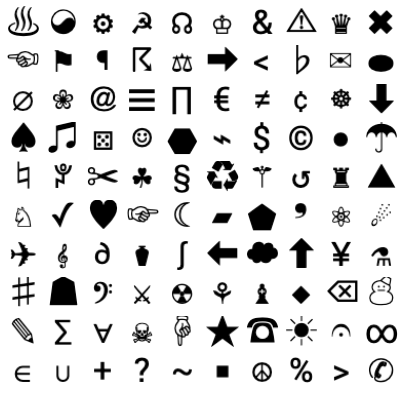

In [3]:
fig, axarr = plt.subplots(10, 10, figsize=(7, 7))
for i in range(100):
    j, k = (int(i/10), i%10)
    axarr[j, k].imshow(esbn_img[i], cmap='gray_r')
    axarr[j, k].axis('off')
plt.show()


In [4]:
def create_same_different_dataset(n, same_prob=0.2):
    X = np.empty((n, 2, 32, 32, 1), dtype=float)
    pairs = np.empty((n, 2), dtype=int)
    y = np.empty(n, dtype=int)

    for i in np.arange(n):
        j, k = tuple(np.random.choice(range(100), size=2))
        z = np.random.choice([0,1], p=[1-same_prob, same_prob])
        X[i,0] = esbn_img[j]
        X[i,1] = esbn_img[k]
        pairs[i,0] = j
        pairs[i,1] = k
        if (z == 1) or (j==k):
            X[i,1] = X[i,0]
            pairs[i,1] = pairs[i,0]
            y[i] = 1
        else:
            X[i,1] = esbn_img[k]
            y[i] = 0
            
    return X, y, pairs

def create_rmts_dataset(n, same_prob=0.5):
    X = np.empty((n, 4, 32, 32, 1), dtype=float)
    X_ind = np.empty((n, 4), dtype=int)
    y = np.empty(n, dtype=int)

    for i in np.arange(n):
        j, k, l, m = tuple(np.random.choice(range(100), size=4, replace=False))
        z, w = np.random.choice([0,1], p=[1-same_prob, same_prob], size=2)
        if z==1:
            k = j
        if w==1:
            m = l
        X_ind[i] = [j, k, l, m]
        X[i,0] = esbn_img[j]
        X[i,1] = esbn_img[k]
        X[i,2] = esbn_img[l]
        X[i,3] = esbn_img[m]
        if (z == w): 
            y[i] = 1
        else:
            y[i] = 0
    return X, X_ind, y



In [5]:
X, y, pairs = create_same_different_dataset(1000)
np.mean(y)


0.224

In [11]:
training = (pairs[:,0] <= 75) & (pairs[:,1] <= 75)
testing = np.array([not t for t in training])

X_train = X[training]
y_train = y[training]
pairs_train = pairs[training]

X_test = X[testing]
y_test = y[testing]
pairs_test = pairs[testing]

y_train.shape, y_test.shape

X_val = X_train
y_val = y_train


In [8]:
from abstracters import RelationalAbstracter, RelationalAbstracterLayer, SimpleAbstractor
from seq2seq_abstracter_models import Encoder, AddPositionalEmbedding
from tensorflow.keras import layers, Model, Sequential


class SimpleAbstractorCNN(tf.keras.Model):
    def __init__(self, num_classes, num_layers, num_heads, dff,
            embedding_dim, dropout_rate=0.1, name='cnn_abstractor_classifier'):
        super().__init__(name=name)

        self.cnn_embedder = layers.TimeDistributed(CnnEncoder(ff_dim2=embedding_dim), name='CNN_embedder')
        self.cnn_embedder.trainable = False
        self.abstractor = SimpleAbstractor(num_layers=num_layers, num_heads=num_heads, dff=32, use_pos_embedding=False, mha_activation_type='tanh', name='SimpleAbstractor')
        self.dense_layer = layers.Dense(1, activation='sigmoid', name='dense_layer')

    def call(self, inputs):
        source = inputs

        x = self.cnn_embedder(source)
        abstract_symbols = self.abstractor(x)
        output = self.dense_layer(abstract_symbols[:,0])

        return output
        
class CnnEncoder(tf.keras.Model):
    def __init__(self, ff_dim1=64, ff_dim2=64, name='cnn_encoder'):
        super().__init__(name=name)

        self.conv_layer1 = layers.Conv2D(32, (2, 2), activation='relu')
        self.pool_layer1 = layers.MaxPooling2D((2, 2))
        self.conv_layer2 = layers.Conv2D(32, (2, 2), activation='relu')
        self.pool_layer2 = layers.MaxPooling2D((2, 2))
        self.flatten = layers.Flatten()
        #self.dense1 = layers.Dense(ff_dim1, activation='relu')
        self.dense2 = layers.Dense(ff_dim2, activation='relu')
        self.normalize = layers.LayerNormalization()

    def call(self, inputs):
        source = inputs
        x = self.conv_layer1(source)
        x = self.pool_layer1(x)
        x = self.conv_layer2(x)
        x = self.pool_layer2(x)
        x = self.flatten(x)
        #x = self.dense1(x)
        x = self.dense2(x)
        outputs = self.normalize(x)
        return outputs



In [9]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_abstractor = SimpleAbstractorCNN(num_classes=2, num_layers=1, num_heads=4, dff=64, embedding_dim=64)
cnn_abstractor.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
cnn_abstractor(X[:32])
cnn_abstractor.summary()

Model: "cnn_abstractor_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_embedder (TimeDistribut  multiple                 104832    
 ed)                                                             
                                                                 
 SimpleAbstractor (SimpleAbs  multiple                 70816     
 tractor)                                                        
                                                                 
 dense_layer (Dense)         multiple                  65        
                                                                 
Total params: 175,713
Trainable params: 70,881
Non-trainable params: 104,832
_________________________________________________________________


In [12]:
history = cnn_abstractor.fit(X_train, y_train, validation_data=(X_train, y_train), epochs=100, verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 35ms/step - loss: 0.4970 - binary_accuracy: 0.7471 - val_loss: 0.7293 - val_binary_accuracy: 0.6585
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 0.4635 - binary_accuracy: 0.7947 - val_loss: 0.2441 - val_binary_accuracy: 0.8391
Epoch 3/100
20/20 [==============================] - 0s 20ms/step - loss: 0.2524 - binary_accuracy: 0.8916 - val_loss: 0.0777 - val_binary_accuracy: 0.9754
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 0.1768 - binary_accuracy: 0.9458 - val_loss: 0.0512 - val_binary_accuracy: 0.9951
Epoch 5/100
20/20 [==============================] - 0s 19ms/step - loss: 0.3098 - binary_accuracy: 0.8736 - val_loss: 0.1328 - val_binary_accuracy: 0.9622
Epoch 6/100
20/20 [==============================] - 0s 21ms/step - loss: 0.2138 - binary_accuracy: 0.9130 - val_loss: 0.0589 - val_binary_accuracy: 0.9819
Epoch 7/100
20/20 [==============================] - 0s 21ms/ste

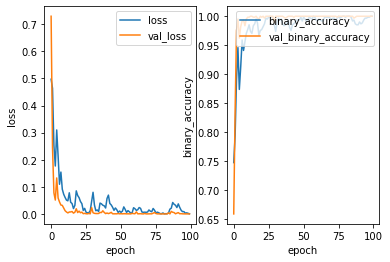

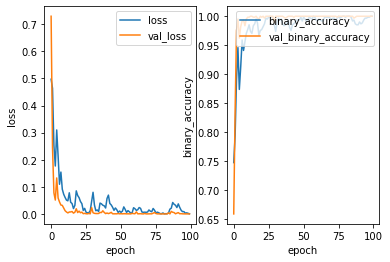

In [13]:
utils.plot_history(history, ('loss', 'binary_accuracy'))


In [14]:
out = cnn_abstractor(X_test)
yhat = np.array([int(p) for p in np.round(out)])
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==y_test)))


test accuracy: 93.09%



In [24]:
E = cnn_abstractor.cnn_embedder(X_test[3:5])
y_test[3:5]
np.sum(np.dot(E[0,0], E[0,1]))

47.09932

In [38]:
# plot predictions

num_objects = 100
prediction_matrix = np.zeros(shape=(num_objects, num_objects))
Z = np.empty((1, 2, 32, 32, 1), dtype=float)

for i in range(num_objects):
    for j in range(num_objects):
        Z[0,0] = esbn_img[i]
        Z[0,1] = esbn_img[j]
        out = cnn_abstractor(Z)
        prediction_matrix[i,j] = np.round(out)


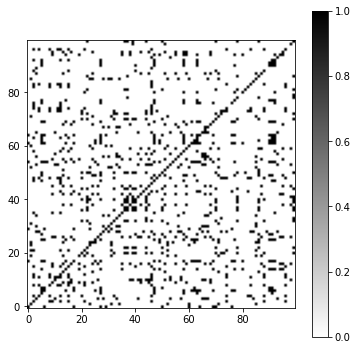

In [13]:

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(prediction_matrix.T, cmap='gray_r')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

In [14]:
# plot relational cross-attention attention scores
relational_crossattention = cnn_abstractor.abstractor.abstracter_layers[0].relational_crossattention.mha

num_objects = 100
relation_matrix = np.zeros(shape=(num_objects, num_objects))
Z = np.empty((1, 2, 32, 32, 1), dtype=float)

for i in range(num_objects):
    for j in range(num_objects):
        Z[0,0] = esbn_img[i]
        Z[0,1] = esbn_img[j]
        object_pair = cnn_abstractor.cnn_embedder(Z)
        attention_output, attention_scores = relational_crossattention(query=object_pair, key=object_pair, 
            value=object_pair, return_attention_scores=True)
        attention_score = np.squeeze(attention_scores)[0][1]
        relation_matrix[i,j] = attention_score



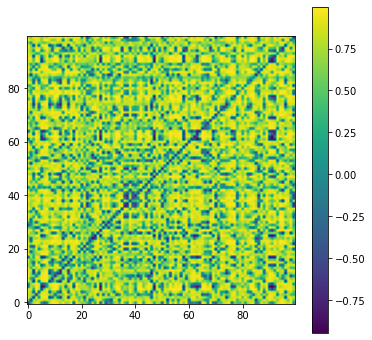

In [15]:

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(relation_matrix.T) #, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

In [16]:
# plot CNN inner-products

num_objects = 100
innerproduct_matrix = np.zeros(shape=(num_objects, num_objects))
Z = np.empty((1, 2, 32, 32, 1), dtype=float)

for i in range(num_objects):
    for j in range(num_objects):
        Z[0,0] = esbn_img[i]
        Z[0,1] = esbn_img[j]
        object_pair = cnn_abstractor.cnn_embedder(Z)
        innerproduct_matrix[i,j] = np.dot(np.array(object_pair[0,0]), np.array(object_pair[0,1]))



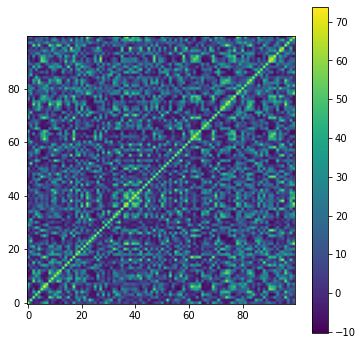

In [17]:

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(innerproduct_matrix.T) #, cmap='gray')
ax.invert_yaxis()
fig.colorbar(im, ax=ax);

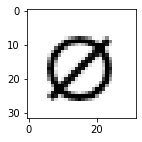

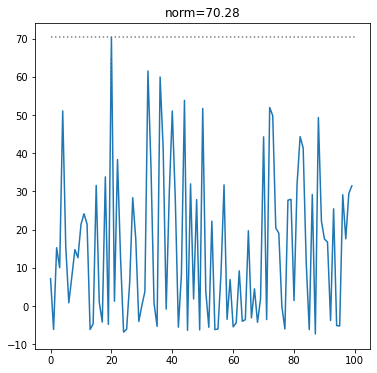

In [18]:
# plot CNN inner-products

num_objects = 100
inner_products = np.zeros(num_objects)
Z = np.empty((1, 2, 32, 32, 1), dtype=float)

i = 20
for j in range(num_objects):
    Z[0,0] = esbn_img[i]
    Z[0,1] = esbn_img[j]
    object_pair = cnn_abstractor.cnn_embedder(Z)
    inner_products[j] = np.dot(np.array(object_pair[0,0]), np.array(object_pair[0,1]))

fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(esbn_img[i], cmap='gray_r')
#_ = ax.axis('off')
fig, ax = plt.subplots(figsize=(6,6))
im = ax.plot(range(num_objects), inner_products) #, cmap='gray')
#ax.set_ylim(55, 65)
ax.vlines(i, ymin=55, ymax=65, linestyle='dotted', color='gray')
ax.hlines(inner_products[i], xmin=0, xmax=num_objects, linestyle='dotted', color='gray')
_ = ax.set_title('norm=%.2f' % inner_products[i])

#object_pair
